# Autoencoders. Часть 2

## Variational autoencoders (VAE)

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем датасет "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан в ячейках ниже

In [1]:
import numpy as np
import pandas as pd
import os

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import skimage.io

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

from matplotlib import pyplot as plt 
import seaborn as sns
sns.set_theme(style="darkgrid", font_scale=1.6)

In [2]:
%pwd

'/home/drapeykonik'

In [3]:
%cd DLSCourse/Autoencoders/

/home/drapeykonik/DLSCourse/Autoencoders


In [4]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    #display(df_attrs.head())
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    #display(df_attrs.head())


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                #print(fpath)
                photo_id = fname[:-4].replace('_',' ').split()
                #print(photo_id)
                person_id = ' '.join(photo_id[:-1])
                #print(person_id)
                photo_number = int(photo_id[-1])
                #print(photo_number)
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    #display(photo_ids.head())
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    #display(df.head())
    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [5]:
all_photos, all_attrs = fetch_dataset()

Давайте построим простейший VAE, который будет состоять из линейных слоев. Обратите особое внимание на метод `reparameterize`. Это так называемый **reparametrization trick**: преобразование, позволяющее перейти от случайной величины, имеющей стандартное нормальное распределение (со средним 0 и дисперсией 1), к произвольной нормальной случайной величине. Такой трюк позволяет нам генерировать латентный вектор из произвольного нормального распределения

In [101]:
FEATURES = 16

class LinearVAE(nn.Module):
  def __init__(self, features):
    super(LinearVAE, self).__init__()
    self.features = features
    self.flatten = nn.Flatten()

    self.encoder = nn.Sequential(
        nn.Linear(in_features=64*64*3, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=2 * features),
    )

    self.decoder = nn.Sequential(
        nn.Linear(in_features=features, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=64*64*3),
    )

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    sample = mu + std * eps
    return sample


  def forward(self, x):
    #encoding
    x = self.flatten(x).float()
    x = self.encoder(x).view(-1, 2, self.features)
    #get `mu` and `log_var`
    mu = x[:, 0, :]
    log_var = x[:, 1, :]
    #get latent vector through reparameterization
    z = self.reparameterize(mu, log_var)
    #decoding
    x = self.decoder(z)
    reconstruction = torch.sigmoid(x).view(-1, 64, 64, 3)
    return reconstruction, mu, log_var

  def sample(self, z):
    generated = self.decoder(z)
    generated = torch.sigmoid(generated)
    generated = generated.view(-1, 64, 64, 3)
    return generated

  def get_latent_vector(self, x):
    x = self.flatten(x).float()
    x = self.encoder(x).view(-1, 2, self.features)
    mu = x[:, 0, :]
    log_var = x[:, 1, :]
    z = self.reparameterize(mu, log_var)
    return z

Определим лосс и его компоненты для VAE:

Из лекций вы узнали, что лосс у VAE состоит из двух частей: KL-дивергенции, отвечающей за то, как далеко друг от друга отстоят распределения, соответствующие разным лицам, и log-likelihood, отвечающий за то, насколько хорошо мы кодируем исходное изображение.
Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [102]:
def KL_divergence(mu, log_var):
  loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return loss

def log_likelihood(x, reconstruction):
  loss = nn.BCELoss(reduction="sum")
  return loss(reconstruction, x)

def loss_vae(x, mu, log_var, reconstruction):
  return KL_divergence(mu, log_var) + log_likelihood(x, reconstruction) 

Обучим модель:

In [103]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Training device: ", device)

Training device:  cuda


In [104]:
criterion = loss_vae
autoencoder = LinearVAE(FEATURES).to(device)
optimizer = torch.optim.Adam(params=autoencoder.parameters())

In [105]:
summary(model=autoencoder, input_size=(64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
            Linear-2                  [-1, 512]       6,291,968
              ReLU-3                  [-1, 512]               0
            Linear-4                   [-1, 32]          16,416
            Linear-5                  [-1, 512]           8,704
              ReLU-6                  [-1, 512]               0
            Linear-7                [-1, 12288]       6,303,744
Total params: 12,620,832
Trainable params: 12,620,832
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.20
Params size (MB): 48.14
Estimated Total Size (MB): 48.39
----------------------------------------------------------------


In [106]:
train_photos, valid_photos, train_attrs, valid_attrs = train_test_split(all_photos, all_attrs, train_size=0.9, shuffle=False)
train_loader = DataLoader(train_photos, batch_size=32)
valid_loader = DataLoader(valid_photos, batch_size=32)

In [107]:
epochs = 50

In [108]:
train_losses = []
valid_losses = []

for epoch in tqdm(range(epochs)):
  autoencoder.train()
  train_losses_epoch = []
  for X_batch in train_loader:
    optimizer.zero_grad()
    reconstruction, mu, log_var = autoencoder(X_batch.to(device))
    loss = criterion(X_batch.to(device).float(), mu, log_var, reconstruction)
    loss.backward()
    optimizer.step()
    train_losses_epoch.append(loss.item())

  train_losses.append(np.array(train_losses_epoch).mean())

  autoencoder.eval()
  valid_losses_epoch = []
  with torch.no_grad():
    for X_batch in valid_loader:
      reconstruction, mu, log_var = autoencoder(X_batch.to(device))
      reconstruction = reconstruction.view(-1, 64, 64, 3)
      loss = criterion(X_batch.to(device).float(), mu, log_var, reconstruction)
      valid_losses_epoch.append(loss.item())
    
    valid_losses.append(np.array(valid_losses_epoch).mean())
  

  0%|          | 0/50 [00:00<?, ?it/s]

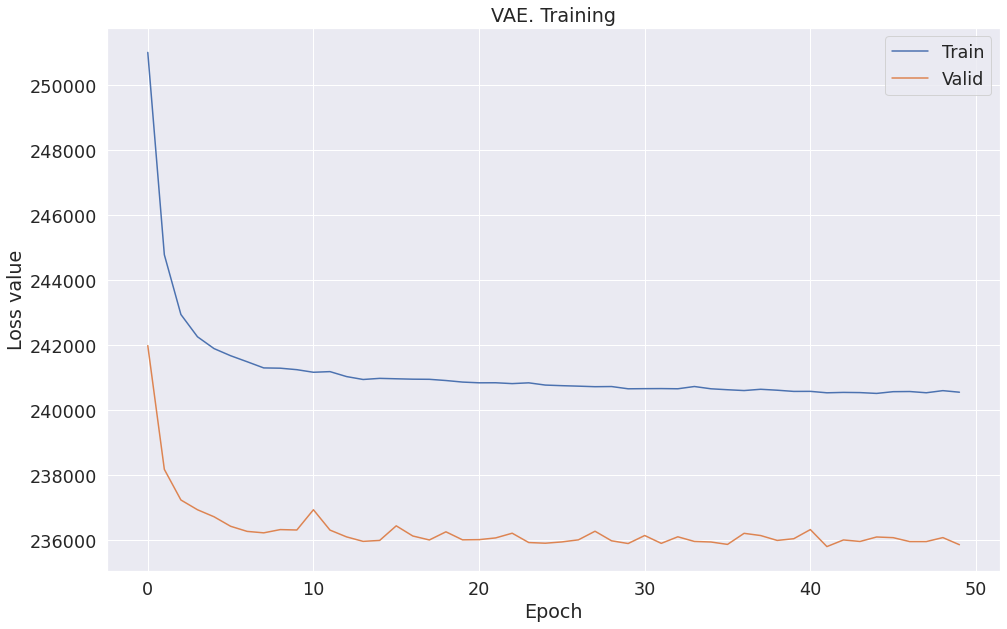

In [109]:
fig = plt.figure(figsize=(16, 10))
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Valid")

plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title("VAE. Training")
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [113]:
autoencoder.eval()
with torch.no_grad():
  for batch in valid_loader:
    reconstruction, mu, log_var = autoencoder(batch.to(device))
    result = reconstruction.cpu().detach().numpy()
    ground_truth = batch.numpy()
    break

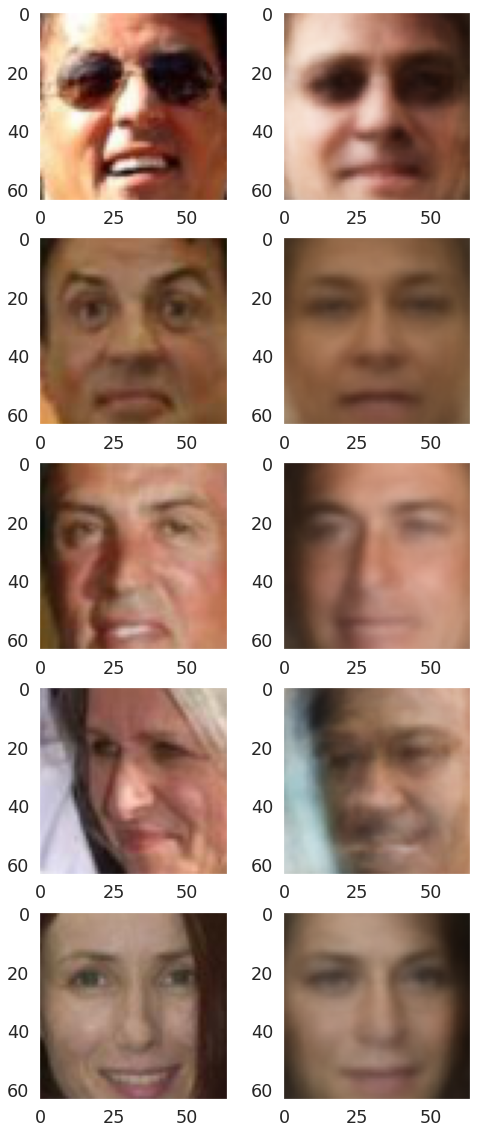

In [120]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2 * i + 1)
  plt.grid(False)
  plt.imshow(gt)
  plt.subplot(5, 2, 2 * i + 2)
  plt.grid(False)
  plt.imshow(res)

Давайте теперь попробуем заняться семплированием из VAE

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [124]:
z = np.array([np.random.normal(0, 1, 16) for i in range(10)])
output = autoencoder.sample(torch.FloatTensor(z).to(device))

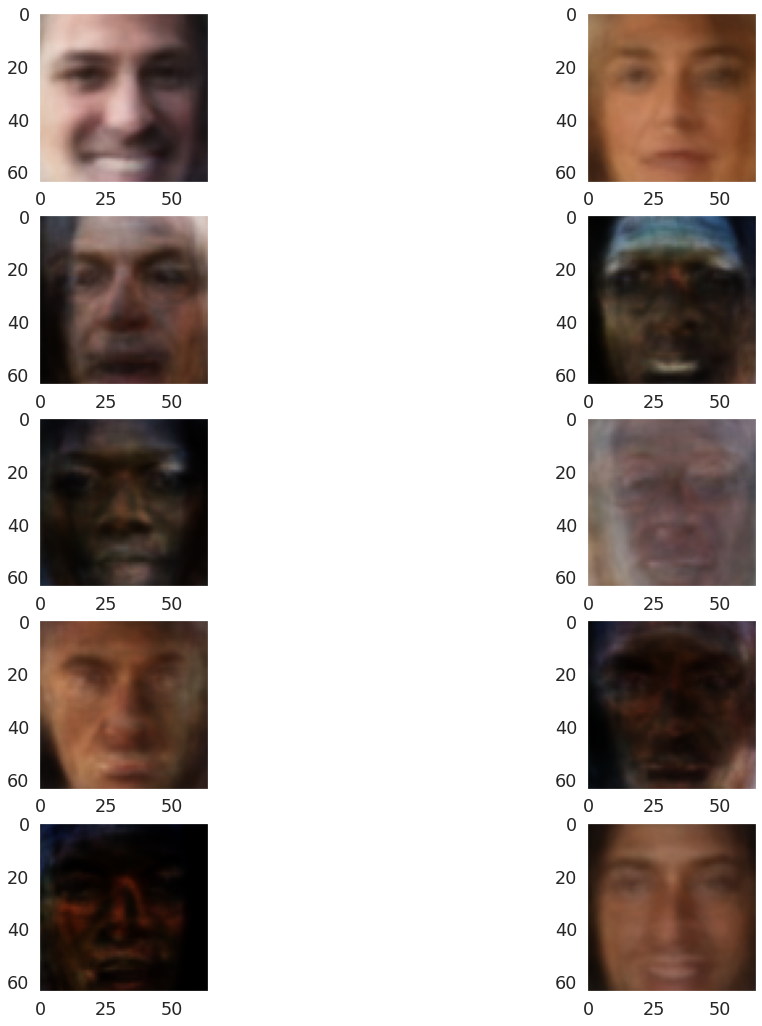

In [125]:
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.grid(False)
  plt.imshow(generated)

## Еще немного экспериментов

Сгенерируем латентные векторы для двух изображений

In [128]:
gt_0 = torch.FloatTensor(ground_truth[0]).to(device)
gt_1 = torch.FloatTensor(ground_truth[1]).to(device)

torch.Size([64, 64, 3])


In [129]:
first_latent_vector = autoencoder.get_latent_vector(gt_0[None, :, :, :])
second_latent_vector = autoencoder.get_latent_vector(gt_1[None, :, :, :])

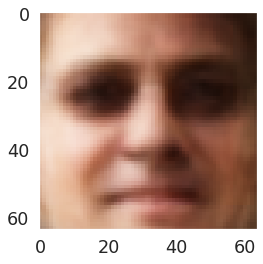

In [135]:
plt.imshow(autoencoder.sample(first_latent_vector)[0].cpu().detach().numpy())
plt.grid(False)

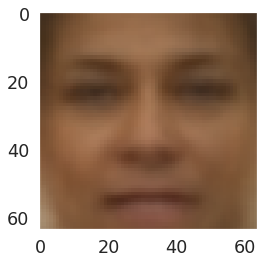

In [136]:
plt.imshow(autoencoder.sample(second_latent_vector)[0].cpu().detach().numpy())
plt.grid(False)

Теперь посмотрим, как будет выглядеть их *выпуклая комбинация*: $\alpha l_1 + (1 - \alpha)l_2$, где $l_1, l_2$ – латентные векторы, $\alpha \in [0, 1]$

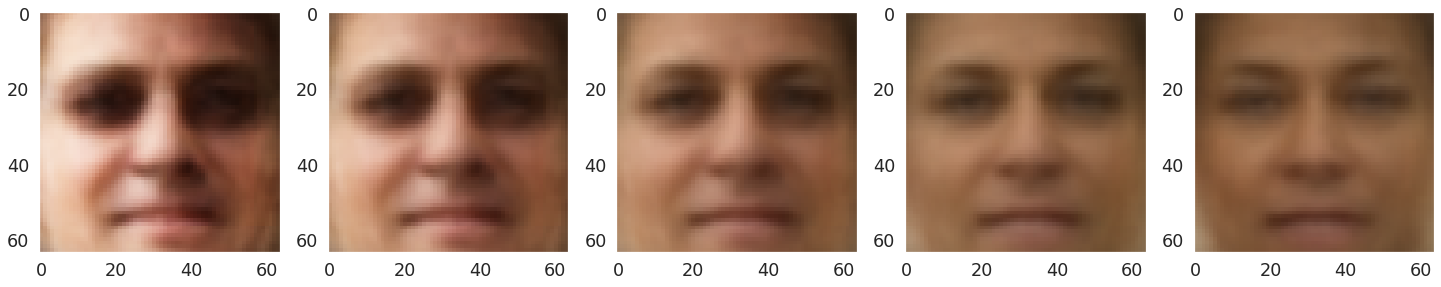

In [142]:
plt.figure(figsize=(25, 5))
for i, alpha in enumerate(np.linspace(0., 1., 5)):
  plt.subplot(1, 5, i + 1)
  latent = second_latent_vector * alpha + (1 - alpha) * first_latent_vector
  image = autoencoder.sample(latent)[0].cpu().detach().numpy()
  plt.imshow(image)
  plt.grid(False)